In [1]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib
import matplotlib.pyplot as plt

import torchvision
from torchvision.datasets import ImageFolder
from torchvision import transforms

import numpy

from IPython.display import Image
from tqdm.notebook import tqdm
from math import *


In [2]:
# Set dataset and model

# Dataset
dataset = torchvision.datasets.CIFAR100

# Pre-trained model
from torchvision.models import resnet152
model = resnet152(pretrained=True)

model_filename = "cifar100-resnet152"

warmup_epoch = 0
num_epoch = 7

lr_base = 1e-3
lr_min = 1e-3

device = "cuda:2" if torch.cuda.is_available() else "cpu"

In [3]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(224),
    transforms.CenterCrop(224)
])
train_set = dataset("./data", train = True, download = True, transform=transform)
test_set = dataset("./data", train = False, download = True, transform=transform)
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

Files already downloaded and verified
Files already downloaded and verified


torch.Size([3, 224, 224])


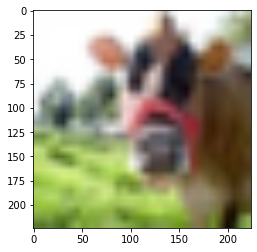

In [4]:
print(train_set[0][0].shape)
plt.imshow(train_set[0][0].permute(1,2,0).numpy()[:,:,::])
plt.show()

In [5]:
in_features = model.fc.in_features
in_features

2048

In [6]:
model.fc = nn.Linear(in_features,len(train_set.classes)) # set in_features and out_features
model.train()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [7]:
# Freeze layers
for name, param in model.named_parameters():
    if ('fc' in name) or ('layer4' in name) or ('layer3' in name): # 
        print("Unfreeze " + name)
        param.requires_grad = True
    else:
        print("Freeze " + name)
        param.requires_grad = False

Freeze conv1.weight
Freeze bn1.weight
Freeze bn1.bias
Freeze layer1.0.conv1.weight
Freeze layer1.0.bn1.weight
Freeze layer1.0.bn1.bias
Freeze layer1.0.conv2.weight
Freeze layer1.0.bn2.weight
Freeze layer1.0.bn2.bias
Freeze layer1.0.conv3.weight
Freeze layer1.0.bn3.weight
Freeze layer1.0.bn3.bias
Freeze layer1.0.downsample.0.weight
Freeze layer1.0.downsample.1.weight
Freeze layer1.0.downsample.1.bias
Freeze layer1.1.conv1.weight
Freeze layer1.1.bn1.weight
Freeze layer1.1.bn1.bias
Freeze layer1.1.conv2.weight
Freeze layer1.1.bn2.weight
Freeze layer1.1.bn2.bias
Freeze layer1.1.conv3.weight
Freeze layer1.1.bn3.weight
Freeze layer1.1.bn3.bias
Freeze layer1.2.conv1.weight
Freeze layer1.2.bn1.weight
Freeze layer1.2.bn1.bias
Freeze layer1.2.conv2.weight
Freeze layer1.2.bn2.weight
Freeze layer1.2.bn2.bias
Freeze layer1.2.conv3.weight
Freeze layer1.2.bn3.weight
Freeze layer1.2.bn3.bias
Freeze layer2.0.conv1.weight
Freeze layer2.0.bn1.weight
Freeze layer2.0.bn1.bias
Freeze layer2.0.conv2.weight
F

In [8]:
# Reading whole dataloader into memory can improve the speed of training
train_loader = list(train_loader)

In [9]:
loss_function = nn.CrossEntropyLoss()

In [10]:
lr = lr_base
def adjust_learning_rate(optimizer, current_epoch, max_epoch, lr_min=lr_min, lr_max=lr_base, warmup=True):
    if current_epoch < warmup_epoch:
        lr = lr_max * (current_epoch+1) / (warmup_epoch+1)
    else:
        lr = lr_min + (lr_max-lr_min)*(1 + cos(pi * (current_epoch - warmup_epoch) / (max_epoch - warmup_epoch))) / 2
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr
    print("Learning rate is set to "+str(lr))

optimiser = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), 
                      lr=lr,
                      momentum=0.9) #only optimse non-frozen layers
model.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [11]:
results = []

for epoch in range(warmup_epoch+num_epoch):
    running_loss = 0
    train_acc = 0
    
    adjust_learning_rate(optimizer=optimiser,
                        current_epoch=epoch,
                        max_epoch=warmup_epoch+num_epoch)
    with tqdm(train_loader, desc='Train(epoch'+str(epoch)+')') as t:
        total = 0
        correct = 0
        for data in t:
            model.train()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            optimiser.zero_grad()

            outputs = model(inputs)
            loss = loss_function(outputs, labels)
            running_loss += loss.item()
            loss.backward()
            optimiser.step()
            
            pred = torch.argmax(F.softmax(outputs), dim=1)
            total += len(labels)
            correct += sum(pred == labels)
            
        train_acc = (100.0 * correct) / total

        t.set_postfix(running_loss=running_loss,
                      runing_acc=train_acc)
            
    print("epoch %d/%d:(tr)loss=%.4f" % (epoch, warmup_epoch+num_epoch, running_loss))
    print("epoch %d/%d:(tr)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, train_acc))
    
    test_running_loss = 0
    test_acc = 0

    with tqdm(test_loader, desc='test'+str(epoch)) as t:
        with torch.no_grad():
            total = 0
            correct = 0
            for data in t:
                model.eval()
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)

                loss = loss_function(outputs, labels)
                test_running_loss += loss.item()
                            
                pred = torch.argmax(F.softmax(outputs), dim=1)
                total += len(labels)
                correct += sum(pred == labels)
            test_acc = (100.0 * correct) / total

            t.set_postfix(running_loss=test_running_loss,
                          runing_acc=test_acc)

    print("epoch %d/%d:(te)loss=%.4f" % (epoch, warmup_epoch+num_epoch, test_running_loss))
    print("epoch %d/%d:(te)acc=%.4f%%" % (epoch, warmup_epoch+num_epoch, test_acc))
          
    results.append({'running_loss':running_loss,
                   'train_acc':train_acc,
                   'test_running_loss':test_running_loss,
                   'test_acc':test_acc})


Learning rate is set to 0.001


Train(epoch0):   0%|          | 0/782 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:26: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/7:(tr)loss=1540.9513
epoch 0/7:(tr)acc=56.9000%


test0:   0%|          | 0/157 [00:00<?, ?it/s]

/home/hf5n21/.conda/envs/pytorch/lib/python3.7/site-packages/ipykernel_launcher.py:55: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


epoch 0/7:(te)loss=124.6935
epoch 0/7:(te)acc=77.6600%
Learning rate is set to 0.001


Train(epoch1):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 1/7:(tr)loss=482.3802
epoch 1/7:(tr)acc=82.5680%


test1:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 1/7:(te)loss=96.1948
epoch 1/7:(te)acc=81.5400%
Learning rate is set to 0.001


Train(epoch2):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 2/7:(tr)loss=238.5308
epoch 2/7:(tr)acc=91.7620%


test2:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 2/7:(te)loss=90.4257
epoch 2/7:(te)acc=82.3500%
Learning rate is set to 0.001


Train(epoch3):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 3/7:(tr)loss=108.1547
epoch 3/7:(tr)acc=97.0100%


test3:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 3/7:(te)loss=93.8738
epoch 3/7:(te)acc=82.6400%
Learning rate is set to 0.001


Train(epoch4):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 4/7:(tr)loss=45.9027
epoch 4/7:(tr)acc=99.1880%


test4:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 4/7:(te)loss=97.2159
epoch 4/7:(te)acc=82.4500%
Learning rate is set to 0.001


Train(epoch5):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 5/7:(tr)loss=21.5163
epoch 5/7:(tr)acc=99.7720%


test5:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 5/7:(te)loss=99.7264
epoch 5/7:(te)acc=82.6700%
Learning rate is set to 0.001


Train(epoch6):   0%|          | 0/782 [00:00<?, ?it/s]

epoch 6/7:(tr)loss=12.3283
epoch 6/7:(tr)acc=99.8880%


test6:   0%|          | 0/157 [00:00<?, ?it/s]

epoch 6/7:(te)loss=102.6697
epoch 6/7:(te)acc=82.4000%


In [12]:
results

[{'running_loss': 1540.9513058662415,
  'train_acc': tensor(56.9000, device='cuda:2'),
  'test_running_loss': 124.69348067045212,
  'test_acc': tensor(77.6600, device='cuda:2')},
 {'running_loss': 482.3802378773689,
  'train_acc': tensor(82.5680, device='cuda:2'),
  'test_running_loss': 96.1947822868824,
  'test_acc': tensor(81.5400, device='cuda:2')},
 {'running_loss': 238.53080081939697,
  'train_acc': tensor(91.7620, device='cuda:2'),
  'test_running_loss': 90.4257088303566,
  'test_acc': tensor(82.3500, device='cuda:2')},
 {'running_loss': 108.15471373125911,
  'train_acc': tensor(97.0100, device='cuda:2'),
  'test_running_loss': 93.87376381456852,
  'test_acc': tensor(82.6400, device='cuda:2')},
 {'running_loss': 45.902663281187415,
  'train_acc': tensor(99.1880, device='cuda:2'),
  'test_running_loss': 97.21585689485073,
  'test_acc': tensor(82.4500, device='cuda:2')},
 {'running_loss': 21.516346140764654,
  'train_acc': tensor(99.7720, device='cuda:2'),
  'test_running_loss': 99

In [13]:
torch.save(model.state_dict(), "model/" + model_filename)

In [14]:
train_loss_list = []
train_acc_list = []
for result in results:
    train_loss_list.append(result["running_loss"])
    train_acc_list.append(torch.Tensor.cpu(result["train_acc"]))

In [15]:
test_loss_list = []
test_acc_list = []
for result in results:
    test_loss_list.append(result["test_running_loss"])
    test_acc_list.append(torch.Tensor.cpu(result["test_acc"]))

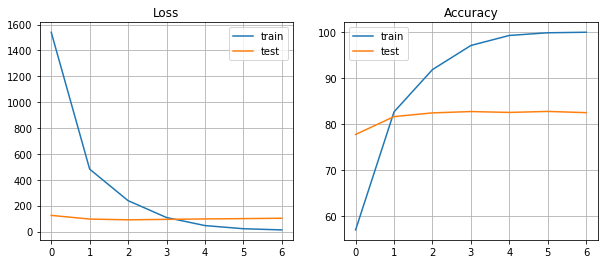

In [16]:
fig, ax = plt.subplots(1, 2, figsize=(10,4))

ax[0].plot(train_loss_list)
ax[0].plot(test_loss_list)
ax[0].legend(['train','test'])
ax[0].grid()
ax[0].set_title("Loss")

ax[1].plot(train_acc_list)
ax[1].plot(test_acc_list)
ax[1].legend(['train','test'])
ax[1].grid()
ax[1].set_title("Accuracy")
plt.show()